> Parts of this notebook may no longer work with other parts. It also may not be the most up-to-date copy on my machine, since I use it for scratch work.

# Preliminary

In [162]:
### Imports, globals, etc.
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import random
import os
%matplotlib inline

ROOT_DIR = '/home/trevor/Projects/iot-diff/data/filtered'
DATA_FILE = 'features.csv'
DATA_PATH = os.path.join(ROOT_DIR, DATA_FILE)

In [179]:
device_categories = {
    'hub': [
        'd0-52-a8-00-67-5e', 
        '44-65-0d-56-cc-d3'
    ],
    'camera': [
        '70-ee-50-18-34-43',
        'f4-f2-6d-93-51-f1',
        '00-16-6c-ab-6b-88',
        '30-8c-fb-2f-e4-b2',
        '00-62-6e-51-27-2e',
        'e8-ab-fa-19-de-4f',
        '00-24-e4-11-18-a8'
    ],
    'switch': [
        'ec-1a-59-79-f4-89',
        '50-c7-bf-00-56-39',
        '74-c6-3b-29-d7-1d',
        'ec-1a-59-83-28-11'
    ],
    'air_quality': [
        '18-b4-30-25-be-e4',
        '70-ee-50-03-b8-ac'
    ],
    'healthcare': [
        '00-24-e4-1b-6f-96',
        '74-6a-89-00-2e-25',
        '00-24-e4-20-28-c6'
    ],
    'lightbulbs': [
        'd0-73-d5-01-83-08'
    ],
    'electronics': [
        '18-b7-9e-02-20-44',
        'e0-76-d0-33-bb-85',
        '70-5a-0f-e4-9b-c0'
    ]
}

device_names = {
    'd0-52-a8-00-67-5e': 'Smart_Things',
    '44-65-0d-56-cc-d3': 'Amazon_Echo',
    '70-ee-50-18-34-43': 'Netatmo_Welcome',
    'f4-f2-6d-93-51-f1': 'TP-Link_Day_Night_Cloud_Camera',
    '00-16-6c-ab-6b-88': 'Samsung_SmartCam',
    '30-8c-fb-2f-e4-b2': 'Dropcam',
    '00-62-6e-51-27-2e': 'Insteon_Camera_wired',
    'e8-ab-fa-19-de-4f': 'Insteon_Camera_wireless',
    '00-24-e4-11-18-a8': 'Withings_Smart_Baby_Monitor',
    'ec-1a-59-79-f4-89': 'Belkin_Wemo_Switch',
    '50-c7-bf-00-56-39': 'TP-Link_Smart_Plug',
    '74-c6-3b-29-d7-1d': 'iHome',
    'ec-1a-59-83-28-11': 'Belkin_Wemo_motion_sensor',
    '18-b4-30-25-be-e4': 'NEST_Protect_smoke_alarm',
    '70-ee-50-03-b8-ac': 'Netatmo_weather_station',
    '00-24-e4-1b-6f-96': 'Withings_smart_scale',
    '74-6a-89-00-2e-25': 'Blipcare_blood_pressure_meter',
    '00-24-e4-20-28-c6': 'Withings_aura_sleep_sensor',
    'd0-73-d5-01-83-08': 'LiFX_Smart_bulb',
    '18-b7-9e-02-20-44': 'Triby_speaker',
    'e0-76-d0-33-bb-85': 'PIX-STAR_photo_frame',
    '70-5a-0f-e4-9b-c0': 'HP_printer',
    'noniot': 'non_iot'
}

def assign_category(device):
    for k, v in device_categories.items():
        if device in v:
            return k
    return 'non_iot'

def mac_to_name(mac):
    return device_names[mac]

In [203]:
df = pd.read_csv(DATA_PATH)

# Drop NaN values
df.fillna(df.groupby('device').mean(), inplace=True)
df.fillna(df.mean(), inplace=True)

# Add device categories
df['device_category'] = df.apply(lambda row: assign_category(row['device']), axis=1)

# Training

In [204]:
kmeans = KMeans(n_clusters=100).fit(df[df.columns[2:-1]])
df['cluster'] = kmeans.labels_

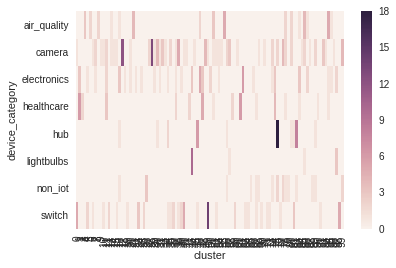

In [205]:
df2 = df.pivot_table(index='device_category', columns='cluster', aggfunc=len, fill_value=0)
sb.heatmap(df2['device'])

In [120]:
# Try removing each device from the training data and testing on it
def cycle_remove_devices(data, device_categories):
    bags = []
    prob_preds = []
    for c, ds in device_categories.items():
        for d in ds:
            # Train/test split
            train = data[data['device']!=d]
            test = data[data['device']==d]
            # Train
            features = df.columns[2:-1]
            clf = RandomForestClassifier()
            y = train['device_category']
            clf.fit(train[features], y.values.ravel())
            # Test
            ps = clf.predict(test[features])
            gt = assign_category(d)
            bags.insert(0, {
                'device': mac_to_name(d),
                'ground_truth': gt,
                'accuracy': len([p for p in ps if p==gt])/len(ps),
                'consensus': Counter(ps).most_common(1)[0][0]
            })
            for row in clf.predict_proba(test[features]):
                dev_dict = dict(zip(clf.classes_, row))
                dev_dict['device'] = d
                dev_dict['ground_truth'] = c
                prob_preds.insert(0, dev_dict)
    return bags, prob_preds
            
bags, prob_preds = cycle_remove_devices(df, device_categories)

bag_cols = ['device', 'ground_truth', 'consensus', 'accuracy']
bag_df = pd.DataFrame(bags)[bag_cols].sort_values(by='accuracy').reset_index(drop=True)

prob_cols = ['device', 'ground_truth', 'hub', 'camera', 'switch', 
             'air_quality', 'healthcare', 'lightbulbs', 'electronics',
             'non_iot']
prob_df = pd.DataFrame(prob_preds)[prob_cols].sort_values(by=['ground_truth', 'device']).reset_index(drop=True)

bag_df.round(decimals=3)

,device,ground_truth,consensus,accuracy
0,HP_printer,electronics,switch,0.000
1,TP-Link_Day_Night_Cloud_Camera,camera,electronics,0.000
2,Dropcam,camera,healthcare,0.000
3,Withings_Smart_Baby_Monitor,camera,healthcare,0.000
4,TP-Link_Smart_Plug,switch,camera,0.000
5,Amazon_Echo,hub,camera,0.000
6,NEST_Protect_smoke_alarm,air_quality,healthcare,0.000
7,iHome,switch,camera,0.000
8,Withings_aura_sleep_sensor,healthcare,camera,0.000
9,LiFX_Smart_bulb,lightbulbs,electronics,0.000


In [149]:
# Randomly remove 30% of device categories (i.e. 7 devices) from the 
# training set then test on them
def holdout(data, device_names, n=1000):
    runs = []
    for i in range(n):
        # Train/test split
        holdout_devices = random.sample(list(device_names.keys()), 7)
        train = data[~data['device'].isin(holdout_devices)]
        test = data[data['device'].isin(holdout_devices)]
        # Train
        features = df.columns[2:-1]
        clf = RandomForestClassifier()
        clf.fit(train[features], train['device_category'])
        # Test
        score = clf.score(test[features], test['device_category'])
        runs.insert(0, {
            'devices': holdout_devices,
            'accuracy': score
        })
    return runs
        
holdout_df = pd.DataFrame(holdout(df, device_names))
holdout_df['devices'] = holdout_df['devices'].apply(lambda d: [mac_to_name(x) for x in d])
holdout_df[['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']] = pd.DataFrame([x for x in holdout_df.devices])
holdout_df = holdout_df.drop('devices', axis=1)

# Visualizations

/home/trevor/Software/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


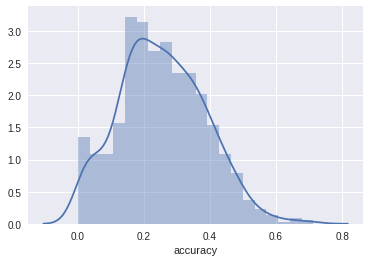

In [160]:
sb.distplot(holdout_df['accuracy'])

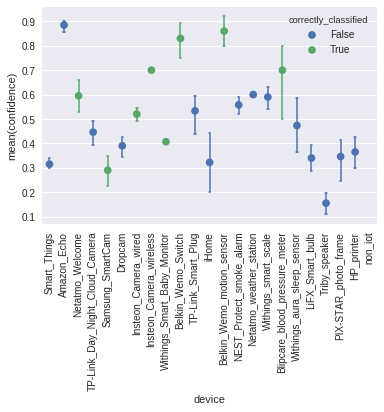

In [118]:
bar_df = pd.melt(prob_df, id_vars=['device', 'ground_truth'],
                 var_name='category', value_name='confidence')
bar_df['device'] = bar_df['device'].apply(mac_to_name)
consensi = bag_df.set_index('device')['consensus']
bar_df['consensus'] = bar_df['device'].apply(lambda x: consensi[x])
bar_df = bar_df[(bar_df['category']==bar_df['consensus'])]#&(bar_df['ground_truth']!=bar_df['consensus'])]
bar_df['correctly_classified'] = bar_df['ground_truth']==bar_df['consensus']

fig = sb.pointplot(x='device', y='confidence', 
                   order=list(device_names.values()), 
                   hue='correctly_classified', data=bar_df, 
                   join=False, errwidth=1.5, capsize=0.1, scale=0.75)
for l in fig.get_xticklabels():
    l.set_rotation(90)

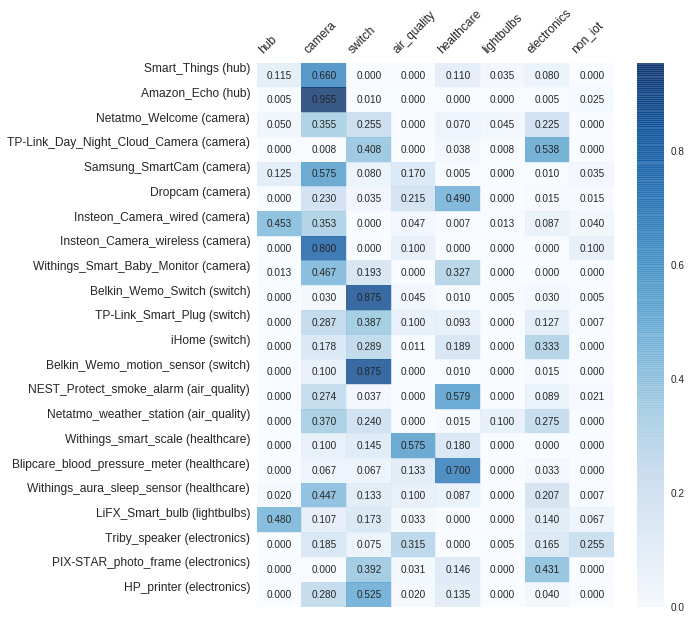

In [185]:
fig, ax = plt.subplots()

ft_cycle_df = prob_df.groupby('device').mean().fillna(0)
index_order = list(device_names.keys())[:-1]
ft_cycle_df = ft_cycle_df.reindex(index_order)
heatmap = ax.pcolor(ft_cycle_df, cmap=plt.cm.Blues, alpha=0.8)
plt.colorbar(heatmap)

data = ft_cycle_df.values
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x+0.5, y+0.5, '%.3f' % data[y][x], ha='center', 
                 va='center', size=10)

fig = plt.gcf()
fig.set_size_inches(8, 10)

ax.set_frame_on(False)
ax.set_yticks(np.arange(ft_cycle_df.shape[0] + 0.5), minor=False)
ax.set_xticks(np.arange(ft_cycle_df.shape[1] + 0.5), minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()

xlabels = ft_cycle_df.columns
ylabels = [mac_to_name(d)+' ('+assign_category(d)+')' for d in ft_cycle_df.index]
ax.set_xticklabels(xlabels, fontsize=12, va='bottom', ha='left', rotation=45)
ax.set_yticklabels(ylabels, fontsize=12, va='top')
pass

(0.0, 1.025)

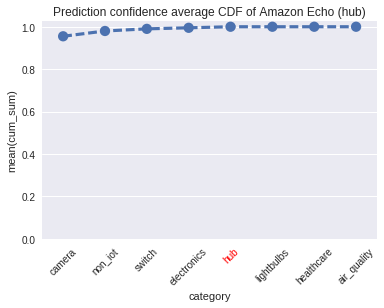

In [110]:
mac = '44-65-0d-56-cc-d3' # Amazon Echo
conf_df = prob_df[prob_df['device']==mac].mean().sort_values()[::-1].cumsum()
conf_df = conf_df.to_frame().reset_index(level=0)
conf_df.columns = ['category', 'cum_sum']
pp = sb.pointplot(x='category',
                  y='cum_sum',
                  data=conf_df,
                  markers=['o'],
                  linestyles=['--'])
for x in pp.get_xticklabels():
    x.set_rotation(45)
    if x.get_text() == 'hub':
        x.set_color('red')
pp.set_title('Prediction confidence average CDF of Amazon Echo (hub)')
plt.ylim(0., 1.025)

In [6]:
# Train
features = df.columns[2:-1]
clf = RandomForestClassifier()
y = train['device_category']
clf.fit(train[features], y.values.ravel())

NameError: name 'train' is not defined

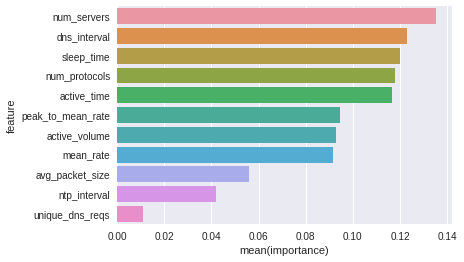

In [169]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

imp_df = pd.DataFrame()
imp_df['importance'] = importances[indices]
imp_df['feature'] = features.values[indices]
import seaborn as sb
%matplotlib inline
sb.barplot(y='feature', x='importance', data=imp_df, orient='h')

(0.0, 1.025)

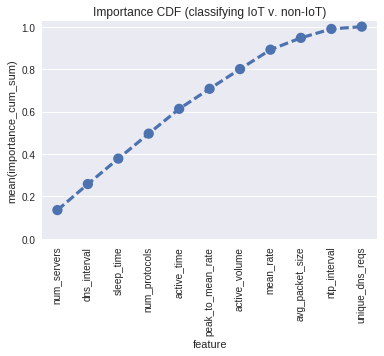

In [170]:
import matplotlib.pyplot as plt

imp_df['importance_cum_sum'] = imp_df.importance.cumsum()
pp = sb.pointplot(x='feature', 
                  y='importance_cum_sum', 
                  data=imp_df,
                  markers=['o'],
                  linestyles=['--'])
for x in pp.get_xticklabels():
    x.set_rotation(90)
pp.set_title('Importance CDF (classifying IoT v. non-IoT)')
plt.ylim(0., 1.025)

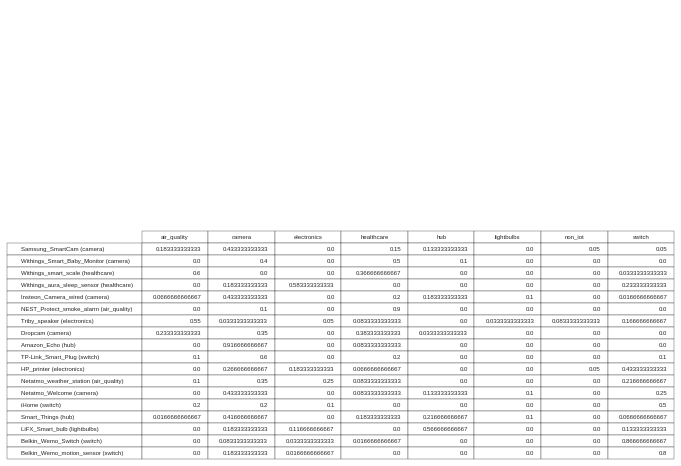

In [212]:
plt.figure(figsize=(21,14))
ax = plt.subplot(321, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ylabels = [mac_to_name(d)+' ('+assign_category(d)+')' for d in ft_cycle_df.index]
fig = pd.tools.plotting.table(ax, ft_cycle_df, rowLabels=ylabels)
plt.savefig('fig.png', dpi=300)